# Automatic commissioning notebook
In this notebook I attempt to automate the process of commissioning new devices. It connects via serial port to the different devices and calls the differents commands in order to create a thread network and configure it's clients.

Been following this guide: https://codelabs.developers.google.com/codelabs/openthread-hardware/#0

In [33]:
import serial
import os

In [7]:
!echo $USER

usuario


First step is to discover the present devices in the computer.

In [162]:
result = os.popen('find /dev/serial/by-id/ -maxdepth 1 -type l -ls | cut -d"/" -f5- ').read()

In [163]:
def get_devices():
    result = os.popen('find /dev/serial/by-id/ -maxdepth 1 -type l -ls | cut -d"/" -f5- ').read()
    print (result)
    values = [line[-1] for line in result.splitlines()]
    return values

In [178]:
usbs = get_devices()

usb-Silicon_Labs_Zolertia_Firefly_platform_ZOL-B001-A200001546-if00-port0 -> ../../ttyUSB1
usb-Silicon_Labs_Zolertia_Firefly_platform_ZOL-B001-A200001544-if00-port0 -> ../../ttyUSB0



In [179]:
commissioner = serial.Serial('/dev/ttyUSB'+usbs[0], 115200, timeout=0.5)

In [180]:
joiner = serial.Serial('/dev/ttyUSB'+usbs[1], 115200, timeout=0.5)

In [151]:
def read_answer(serial_d, back=False, ending_ar=None, timeout=None):
    # Reads and analyzes the response

    # Initial variables
    ret = []
    counter = 0

    # Check if using the default values or different
    # this is used to check the connection successful
    if ending_ar:
        endings = ending_ar
    else:
        endings = ["> ", "Done\r\n"]
    
    data = ""
    while not (data in endings):
        data = serial_d.readline().decode('ascii')
        ret.append(data)
        # Prints the received data
        print(data, end="")

        # It checks that counter is a value and the condition
        if timeout and counter>timeout:
            # If we are over the timeout we will send \n to wake up the cli
            serial_d.write(("\n").encode())
            return

        counter = counter + 1
    if back:
        return ret

In [152]:
def send_command(serial_d, command, back=False, ending_ar=None, timeout=None):
    # Sends command and reads the response
    serial_d.write((command+"\n").encode())
    return read_answer(serial_d, back, ending_ar, timeout)

In [181]:
# initialize the commissioner
init_commands = [
    "dataset init new",
    "dataset",
    "dataset commit active",
    "panid 0xdead",
    "ifconfig up",
    "thread start",
    "ipaddr"]

for command in init_commands:
    send_command(commissioner, command)

dataset init new
Done
> dataset
Active Timestamp: 1
Channel: 26
Channel Mask: 07fff800
Ext PAN ID: fe3c51f31c666cd7
Mesh Local Prefix: fd2b:d40d:ebee:1d1f/64
Master Key: 0293ac7639f4d10361f3110ec223d2bc
Network Name: OpenThread-8537
PAN ID: 0x8537
PSKc: e7992eaf49d10652fe81508fa17bf3e9
Security Policy: 0, onrcb
Done
> dataset commit active
Done
> panid 0xdead
Done
> ifconfig up
Done
> thread start
Done
> ipaddr
fd2b:d40d:ebee:1d1f:0:ff:fe00:e000
fd2b:d40d:ebee:1d1f:343c:8efe:5389:8864
fe80:0:0:0:6834:1547:415e:14
Done


In [183]:
# scan the network
send_command(joiner, "scan")
read_answer(joiner, back=False)

scan
| J | Network Name     | Extended PAN     | PAN  | MAC Address      | Ch | dBm | LQI |
+---+------------------+------------------+------+------------------+----+-----+-----+
> | 0 | OpenThread-8537  | fe3c51f31c666cd7 | dead | 6a341547415e0014 | 26 | -31 | 107 |
Done


In [184]:
# get the eui64 from the joiner
commands = send_command(joiner, "eui64", back=True)
euid = commands[1][:-2]

eui64
00124b0014b5ee4a
Done


In [191]:
# Add the euid to the commissioner
send_command(commissioner, "commissioner start")
#read_answer(commissioner, back=False)

> commissioner start
Commissioner: petitioning
Done


In [192]:
send_command(commissioner, f"commissioner joiner add {euid} AAAA")

> Commissioner: active
commissioner joiner add 00124b0014b5ee4a AAAA
Done


In [193]:
send_command(joiner, "ifconfig up")
send_command(joiner, "panid 0xdead")

> ifconfig up
Done
> panid 0xdead
Done


In [194]:
send_command(joiner, "joiner start AAAA")

> joiner start AAAA
Done


In [26]:
send_command(joiner, "ipaddr")

> ipaddr
fd44:8ed8:835:4df8:0:ff:fe00:cc02
fd44:8ed8:835:4df8:2b60:4dbd:e58f:2d5a
fe80:0:0:0:cc05:14a:621c:1d0d


In [16]:
send_command(commissioner, "factoryreset")

factoryreset

KeyboardInterrupt: 

In [28]:
send_command(commissioner, "ping fd44:8ed8:835:4df8:0:ff:fe00:cc02")

ping fd44:8ed8:835:4df8:0:ff:fe00:cc02
> 16 bytes from fd44:8ed8:835:4df8:0:ff:fe00:cc02: icmp_seq=2 hlim=64 time=11ms


KeyboardInterrupt: 

In [196]:
try:
    read_answer(joiner, back=False)
except:
    print("Stopped by the user!")

Join success
Stopped by the user!


In [31]:
try:
    read_answer(commissioner, back=False)
except:
    print("Stopped by the user!")

Stopped by the user!


In [158]:
a = send_command(joiner, "ipaddr", back=True)

> ipaddr
fd33:750b:c7bf:d78a:0:ff:fe00:f000
fd33:750b:c7bf:d78a:dac7:4b6c:37a9:809e
fe80:0:0:0:f4de:c5c9:2f32:23dc
Done


In [159]:
a[1][:-2]

'fd33:750b:c7bf:d78a:0:ff:fe00:f000'

# Abstract classes test

In [7]:
from abc import ABC

In [30]:
class Device(ABC):
    """ Abstract class for the Device object. It exposes a common interface 
    for being used by the main program. It is further implemented
    by the USBDevice, HTTPDevice and MockDevice. """
    
    @abc.abstractmethod
    def __init__(self, color):
        self.color = color
    
    @abc.abstractmethod
    def send_command(self):
        pass
    
    @abc.abstractmethod
    def read_answer(self):
        pass

class USBDevice(Device):
    """ Implementation of the Device class for USB connected platforms. """
    def __init__(self):
        super().__init__("red")
        pass
    def send_command(self):
        pass
    def read_answer(self):
        pass

class HTTPDevice(Device):
    """ Implementation"""
    def send_command(self):
        pass
    def read_answer(self):
        pass

class MockDevice(Device):
    def send_command(self):
        pass
    def read_answer(self):
        pass

In [32]:
p = USBDevice()

TypeError: __init__() takes 2 positional arguments but 3 were given

In [31]:
p.color

'red'

In [1]:
class ob:
    pass

In [2]:
p = ob

In [9]:
mro.mro()

NameError: name 'mro' is not defined

# Graph package tests

In [190]:
def all_to_one():
        """ Creates all to one topology
            Returns:
            - adjacency_dict : dictionary with the pairs id:[connected_ids]
              all the data are integers    
        """
      

        # It is better to use the ids as they are integers and provide a
        # way to decouple the data structures (by means of a join)
        ids = [1,2,3,4,5,6,88]

        # The last element will be the commissioner, so it gets deleted
        # from the list and saved in a variable as it will be used later
        commissioner_id = ids.pop()

        # Create adjacency list with all the current devices connectating
        # to the commissioner
        adjacency_dictionary = {idn: [commissioner_id] for idn in ids}

        # we add the entry for the commissioner and it's ready
        adjacency_dictionary[commissioner_id] = []

        return adjacency_dictionary

In [5]:
from manager import DeviceManager
import os

In [2]:
PAEManager = DeviceManager()

# Get devices(boards) in the system
# devices = PAEManager.get_USBDevices()
devices = PAEManager.get_MockDevices(18)
# devices = PAEManager.get_HTTPDevices()

PAEManager.devices = devices

# TODO: Decouple configuration from the code. Create YAML file with all the configs

# Set topology
top = PAEManager.all_to_one()
PAEManager.topology = top

In [30]:
def plot_graph(self):
    """ Plots the topology 
        It generates an image with the networkx library, stores it in /
        and opens the image
    """

    # Necessary imports
    import networkx as nx
    import matplotlib.pyplot as plt

    # Vars
    lines = []
    
    # networkx needs a list with the following structure:
    # ['1 connected nodes', '2 connected nodes', ... ]
    # It has a string for every node containing the chronological order
    # the connections it has.
    # Example all to one structure:
    # ['1 3', '2 3', '3 ']
    # In this example the first two nodes are connected to the 
    # third node. Note that the index starts at one
    for key,values in self.topology.items():
        
        intermed = ", ".join([str(j+1) for j in values])
        lines.append(f'{key+1} {intermed}')
    
    #lines = ['1 3', '2 3', '3 ']
    
    
    # Create networkx Graph from the adjacency list
    G = nx.parse_adjlist(lines, nodetype = int)
    
    # Get a dict with the labels of every node
    labels = dict((n, self.devices[n-1].name) for n in G.nodes())
    
    # networkx call to generate the image
    nx.draw(G, with_labels=True, font_weight='bold', node_color="powderblue", labels=labels)
    
    # Export image and open with eog
    #plt.savefig('foo.png')
    #os.system("eog foo.png &")

    pass

{1: 'Mock0', 18: 'Mock17', 2: 'Mock1', 3: 'Mock2', 4: 'Mock3', 5: 'Mock4', 6: 'Mock5', 7: 'Mock6', 8: 'Mock7', 9: 'Mock8', 10: 'Mock9', 11: 'Mock10', 12: 'Mock11', 13: 'Mock12', 14: 'Mock13', 15: 'Mock14', 16: 'Mock15', 17: 'Mock16'}
['1 18', '2 18', '3 18', '4 18', '5 18', '6 18', '7 18', '8 18', '9 18', '10 18', '11 18', '12 18', '13 18', '14 18', '15 18', '16 18', '17 18', '18 ']


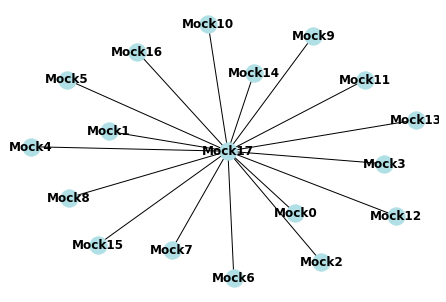

In [31]:
plot_graph(PAEManager)